<!-- # CMPUT 200 Fall 2024  Ethics of Data Science and AI
 -->
# Assignment 2: Fairness Analysis of a Dataset

***
- **FIRST name**: Hooriya Kazmi
- **LAST name**:
- **Student ID**: 1780094
- **Dataset**:

Leave blank if individual:
- **Group member names**: Jillian Kriwokon
- **Group member student IDs**: 1765983
***

In this assignment, you will explore the different fairness metrics learnt in class using a dataset of your choice. Before beginning, you will have to inspect the data and determine the variable of interest (i.e. the outcome) and at least two sensitive features. After each step of your analysis, you will write an in-depth analysis of your results.

This notebook has four stages in which we will:
1. Import the data, implement a few pre-processing steps, and inspect the data
2. Run a short exploratory analysis of the primary variable of interest of your dataset
3. Reproduce the logistic regression model  and interpret the estimates
4. Compute the predictive accuracy of the risk score labels

### Instructions
<!-- **Deadline.**  This assignment is due at ****.  Please check the syllabus for late submissions. -->
You are expected to write clear, detailed, and complete answers when analysing your data. Lack of this may result in point deductions.

**Reminder.** You must submit your own work.  The collaboration policy for the assignments is Consultation Collaboration. You may verbally discuss concepts with your classmates, without exchanging written text, code, or detailed advice.  You must develop your own solution and **submit your own work**.  This means that you **cannot** get your solution from AI tools.   All sources of information used including books, websites, students you talked to, must be cited in the submission.  Please see the course FAQ document for details on this collaboration policy.  We will adhere to current Faculty of Science guidelines on dealing with suspected cases of plagiarism.

You must use this notebook to complete your assignment. You will execute the questions in the notebook. The questions might ask for a short answer in text form or for you to write and execute a piece of code. Make sure you enter your answer in either case only in the cell provided. Do not use a different cell and do not create a new cell. Creating new cells for your code is not compatible with the auto-grading system we are using and thus your assignment will not get grading properly and you will lose marks for that question.

Your submitted notebook should run on our local installation.  So if you are importing packages not listed in the notebook or using local data files not included in the assignment package, make sure the notebook is self-contained with a requirements.txt file or cells in the notebook itself to install the extra packages.  If we cannot run your notebook, you will lose 50% of the marks, and any additional marks that may be lost due to wrong answers.

### Submission Instructions
When you are done, you will submit your work from the notebook. Make sure to save your notebook before running it, and then submit on Canvas the notebook file with your work completed. Name your file with your **Student ID number** and the assignment number (ex: 1234567_A2.ipynb). Failure to do so will result in a zero!

In [ ]:
# Don't change this cell; just run it.
import numpy as np
from numpy.random import default_rng
import pandas as pd
from scipy.optimize import minimize
import statsmodels.api as sm

# These lines do some fancy plotting magic.
import matplotlib
# This is a magic function that renders the figure in the notebook, instead of displaying a dump of the figure object.
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [ ]:
# Don't change this cell; just run it.
rng_seed = 42
rng = default_rng(rng_seed)
rngstate = np.random.RandomState(rng_seed)

## Data
**Question 1.** We will first load the data, carry out some cleaning and pre-processing, and inspect the data to understand what exploratory steps we will take. Name the DataFrame `df_init`.

In [ ]:
# YOUR CODE HERE
df_init = pd.read_csv("titanic.csv")

print("Shape: ", df_init.shape)
df_init.head(5)

Shape:  (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Question 1.1.** Describe your data and its purpose. What are the sensitive variables, features, and target variables? Are there any latent variables?

The data describes individuals onboard the Titanic and whether they survived. We can use this data to explore relationships between passenger characteristics (age, class, and gender) and their survival outcomes. This data can be used in statistical analysis and machine learning models for predicting survival.
The sensitive features sex and passenger class. It is important to note that 1912 was a different time and it was not considered unethical to allow women to go first into life boats, but today, this is more likely to be considered bias. If we remove historical context, this is a sensitive attribute. The features are PassengerId, Name, age, siblings and spouses, parents, ticket, fare, cabin, and embarked location. The target variable is survival, which is a binary variable where 1 is survived and 0 is did not survive. Latent variables are those not included in the dataset that may have impacted the dataset. This could be income, because income would influence how much a person was willing to pay for fare and passenger class. Another latent variable could be citizenship or race, because especially in 1912, these factors influenced socioeconomic status, which could influence passenger class, which could influence survival.

It is crucial, in every data analysis project, to have a good understanding of the data.  This includes:  how the data was collected, what sources the data originate from, how data were merged, what the data columns refer to, etc.  

**Question 2.** Do some investigating online about your dataset. Do they provide a methodology on how the data was collected? How was it analysed? Describe your findings below. (If your data does not have a methodology, describe how you would collect and analyse the data yourself).


It is not exactly clear how this data was collected but we can infer that it was collected from ticket purchase records, survivorship logs, newspapers and key logs to see which passengers were in which rooms. The columns, PassengerId,	Survived (binary 1 for survived or 0 for died)	Pclass(1, 2, or 3 with 1 being most expensive and comfortable)	Name, Sex, Age, SibSp(whether the person had siblings or a spouse onboard), Parch(whether the person had parents or children on board)	Ticket,	Fare (amount paid to board), Cabin, Embarked (port from which they boarded). No explicit methodology was given, but we would make this data set by finding as many data sets as possible with relevant features from the titanic, from historical records and linking them.

### Data pre-processing
**Question 3.** You will now follow your dataset's methodology in pre-processing the data.  Note that your data may not be already filtered, so there may be rows that are not needed or missing values (NaN).  In your pre-processing, first retain only relevant columns for ease of analysis and inspection.  Relevant columns are those that you will need for analysis in this assignment - please read the whole assignment once over to determine which columns to retain.   You will need to retain all columns with sensitive features, the output columns, and other columns that contain features needed for the analysis.  Remember, it's always a good idea to check first all the columns and do any investigation into your dataset, like you were asked in Question 2.  Once you've retained the columns you want, remove the rows that are missing data (if needed).  

Next, determine if you have to do any more filtering (e.g. maybe you only want to consider individuals between 20 and 30 years old). Also decide if there are any any values that you want to remove (e.g. maybe you want to remove people classified as '0' for a medical condition).

In [ ]:
cols_retain = ['Pclass',	'Survived',	'Sex']
df_cleaned = df_init[cols_retain]
df_cleaned.dropna()

,Pclass,Survived,Sex
0,3,0,male
1,1,1,female
2,3,1,female
3,1,1,female
4,3,0,male
...,...,...,...
886,2,0,male
887,1,1,female
888,3,0,female
889,1,1,male


**Question 3.1.** We will be working with your dataset's variable of interest, which is the output, or label.  You would have determined what this should be in the previous questions.  Let's first be certain the values are numeric.  You would use `pd.to_numeric`.  Note that there might be NaN values, and if so, you should drop those rows.

In [ ]:
#Female is 0 and male is 1
df_cleaned['Sex']=np.where(df_cleaned['Sex']=='female',0,1)
df_cleaned

<ipython-input-85-b0587ab1f649>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Sex']=np.where(df_cleaned['Sex']=='female',0,1)


,Pclass,Survived,Sex
0,3,0,1
1,1,1,0
2,3,1,0
3,1,1,0
4,3,0,1
...,...,...,...
886,2,0,1
887,1,1,0
888,3,0,0
889,1,1,1


### Data exploration
Let us now explore the statistics of the data.  Your data contains a variable of interest, which is the output.  Our goal is to compare the analysis of these outputs with the outputs of a logistic regression model we will build ourselves.

We will plot the distribution of the variable of interest according to the first sensitive feature (that you defined in question 1) to see how it differs across different subgroups.

**Question 4.** Let's first create dataframes that are specific to the different subgroups of your sensitive variable.  First choose In the cell below, create the new dataframes `df_1` and `df_2` so that `df_1` holds all the rows that correspond to the first subgroup and `df_2` holds all the rows that correspond to the second subgroup. If there are more than 2 subgroups, find a way to categorize them into two categories. You may change the names so that it's more specific to your dataset.

In [ ]:

Male = df_cleaned[df_cleaned['Sex'] == 1]
Female = df_cleaned[df_cleaned['Sex'] == 0]
Female = Female.drop(columns=['Pclass'])
Male = Male.drop(columns=['Pclass'])
Male
Female

,Survived,Sex
1,1,0
2,1,0
3,1,0
8,1,0
9,1,0
...,...,...
880,1,0
882,0,0
885,0,0
887,1,0


**Question 4.1.** Now we will plot histograms for these new dataframes.  The histogram will have the variable of interest (output varialbe) on the x axis, n bins corresponding to the n values possible. The y axis will be the _proportion_ of individuals of each subgroup that have that variable of interest.  So the y values for each subgroup will be the number of individuals having a given value divided by the total number of individuals of that subgroup.

You can choose how you want to represent the histograms:  separate sub plots side by side, or all on one plot with different colours each, etc.  The axis limits should be same on both plots (same scale) and the plots should have appropriate titles, axis labels, and if needed a legend.

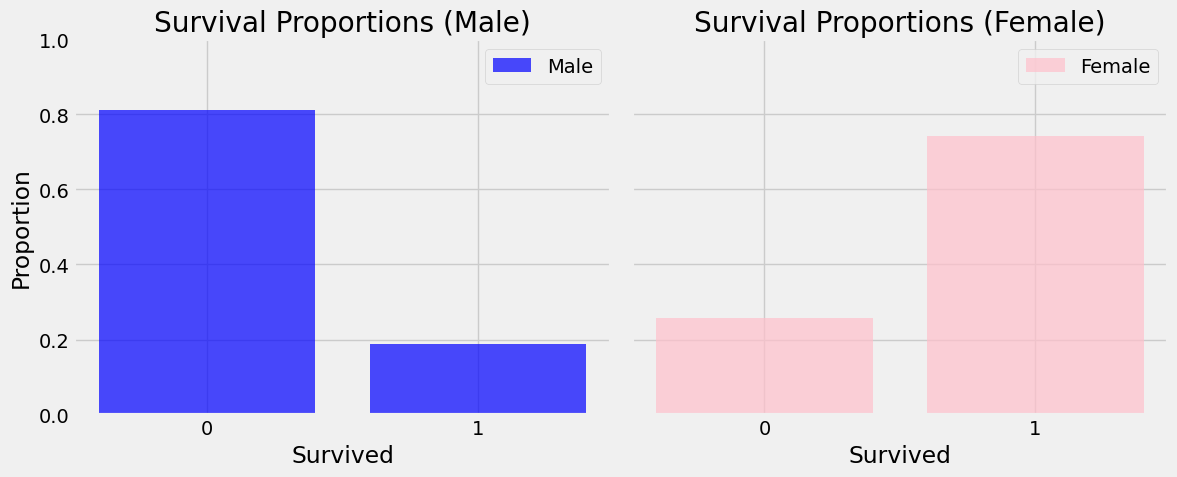

In [ ]:
import matplotlib.pyplot as plt
male_survived_proportions = Male['Survived'].value_counts(normalize=True)
female_survived_proportions = Female['Survived'].value_counts(normalize=True)

# Plotting side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Male plot
axes[0].bar(
    male_survived_proportions.index,
    male_survived_proportions.values,
    color='blue',
    alpha=0.7,
    label='Male'
)
axes[0].set_title('Survival Proportions (Male)')
axes[0].set_xlabel('Survived')
axes[0].set_ylabel('Proportion')
axes[0].set_xticks([0, 1])
axes[0].legend()

# Female plot
axes[1].bar(
    female_survived_proportions.index,
    female_survived_proportions.values,
    color='pink',
    alpha=0.7,
    label='Female'
)
axes[1].set_title('Survival Proportions (Female)')
axes[1].set_xlabel('Survived')
axes[1].set_xticks([0, 1])
axes[1].legend()

axes[0].set_ylim(0, 1)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()



**Question 4.2.** Describe the plots, especially any differences you see between them.  What does this tell you about the distribution of the variable of interest with respect to the sensitive feature?

The plots show that sex may have impacted whether an individual survived. The blue bars of the first plot show that roughly 80% of men died while only 20% survived. The pink bars of the second plot show that rougly 25% women died while 75% survived. This shows that survival (the variable of interest) was more likely for females than for males, so the sensitive feature impacts the output.

We will now consider the second sensitive feature.  Follow the same steps as above.

**Question 5.** Create dataframes that are specific to the subgroups for your second sensitive feature.  In the cell below, create the new dataframes `df_a` and `df_b` so that `df_a` holds all the rows that correspond to the first subgroup and `df_b` holds all the rows that correspond to the second subgroup. If there are more than 2 subgroups, find a way to categorize them into two categories. You may change the names so that it's more specific to your dataset.

In [ ]:
Rich = df_cleaned[df_cleaned['Pclass'] == 1]
Poor = df_cleaned[(df_cleaned['Pclass'] == 2) | (df_cleaned['Pclass'] == 3)]
Rich = Rich.drop(columns=['Sex'])
Poor = Poor.drop(columns=['Sex'])
Rich
Poor

,Pclass,Survived
0,3,0
2,3,1
4,3,0
5,3,0
7,3,0
...,...,...
884,3,0
885,3,0
886,2,0
888,3,0


**Question 5.1.** Now we will plot histograms for these new dataframes.  The histogram will have the variable of interest (output variable) on the x axis, n bins corresponding to the n values possible. The y axis will be the _proportion_ of individuals of each subgroup that have that variable of interest.  So the y values for each subgroup will be the number of individuals having a given value divided by the total number of individuals of that subgroup.

You can choose how you want to represent the histograms:  separate sub plots side by side, or all on one plot with different colours each, etc.  The axis limits should be same on both plots (same scale) and the plots should have appropriate titles, axis labels, and if needed a legend.

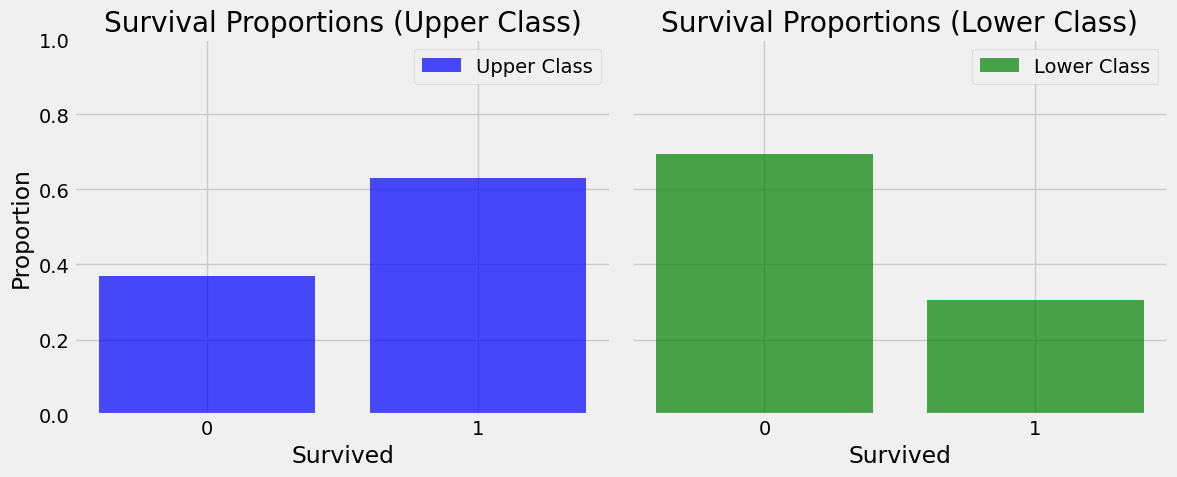

In [ ]:
Rich_survived_proportions = Rich['Survived'].value_counts(normalize=True)
Poor_survived_proportions = Poor['Survived'].value_counts(normalize=True)

# Plotting side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].bar(
    Rich_survived_proportions.index,
    Rich_survived_proportions.values,
    color='blue',
    alpha=0.7,
    label='Upper Class'
)
axes[0].set_title('Survival Proportions (Upper Class)')
axes[0].set_xlabel('Survived')
axes[0].set_ylabel('Proportion')
axes[0].set_xticks([0, 1])
axes[0].legend()

axes[1].bar(
    Poor_survived_proportions.index,
    Poor_survived_proportions.values,
    color='green',
    alpha=0.7,
    label='Lower Class'
)
axes[1].set_title('Survival Proportions (Lower Class)')
axes[1].set_xlabel('Survived')
axes[1].set_xticks([0, 1])
axes[1].legend()

axes[0].set_ylim(0, 1)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


**Question 5.2.** Describe the two plots, especially any differences you see between them.  What does this tell you about the distribution of the variable of interest with respect to the second sensitive feature?

The plots show that upper class people had roughly a 63% chance of survival while lower class people had roughly a 31% chance of surviving. The variable of interest (survival) was distributed more over upper class people. This may indicate that the sensitive feature, passenger class impacted the output, whether an individual survived.

## Fairness / Bias in the Dataset

Now we will develop our own logistic regression model to predict the output given the data and see how it does with respect to fairness metrics.

#### Pre-processing
We first have some preprocessing to do.

Logistic regression is used here as a classification algorithm, so it will give binary outputs. We will use `sklearn`'s logistic regression model which takes numerical input.  Your dataset's features may be categorical variables. If this is the case, we will have to convert the categorical features to numerical features.  We will use [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) for this.

**Question 6.** Let's first set up a dataframe for the label, or target values. In the cell below extract that column into a separate dataframe, our target dataframe. Assign your answer to the variable `Y`.

In [ ]:
Y = df_init['Survived']
Y

,Survived
0,0
1,1
2,1
3,1
4,0
...,...
886,0
887,1
888,0
889,1


**Question 6.1.** Now Let's set up the remaining data. Create another dataframe named `X` that contains every column *except* the target column.

In [ ]:
X = df_init.drop(columns=['Survived'])
X

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


**Question 6.2.** Your analysis should only contain the features that you deem necessary. In the next cell, retain only these columns in our features dataframe `X`.

In [ ]:
cols_retain = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = df_init[cols_retain]
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S
888,3,female,NaN,1,2,23.4500,S
889,1,male,26.0,0,0,30.0000,C


Since we will use `sklearn`'s logistic regression model, we need all our data to be numerical values.  Let's first examine the column types.

Run the following cell to examine the data.

In [ ]:
X.dtypes

,0
Pclass,int64
Sex,object
Age,float64
SibSp,int64
Parch,int64
Fare,float64
Embarked,object


**Question 6.3.** A data type of `object` indicates that the column is categorical.  We will need to convert these to numerical.  We will use one hot encoding on the categorical features. We first separate the numerical and categorical featues using `selector`.  Then we transform the categorial features using one hot encoding and we normalize the numerical features using a scalar.  See for instance here for help on this step: <https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py>

In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

df_selector = df_init.dropna(subset=['Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked', 'Survived', 'Pclass'])

X = df_selector[['Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked', 'Pclass']]
Y = df_selector['Survived']

numerical_features = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Sex', 'Embarked', 'Pclass']

numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

processed_data = preprocessor.fit_transform(X)

cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
num_feature_names = numerical_features
feature_names = list(num_feature_names) + list(cat_feature_names)

processed_df = pd.DataFrame(processed_data, columns=feature_names)
processed_df

,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,-0.527669,0.522511,-0.506787,-0.516380,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.577094,0.522511,-0.506787,0.694046,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,-0.251478,-0.552714,-0.506787,-0.503620,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.369951,0.522511,-0.506787,0.350326,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.369951,-0.552714,-0.506787,-0.501257,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
707,0.646142,-0.552714,5.350885,-0.102875,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
708,-0.182430,-0.552714,-0.506787,-0.407687,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
709,-0.734812,-0.552714,-0.506787,-0.086335,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
710,-0.251478,-0.552714,-0.506787,-0.086335,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


**Question 6.4.** Now we set up the pipeline for our model.  You can refer to the url provided above for help with this step.  You may also need to set `max_iter` to make sure the model converges. Assign your answer to the variable `model`.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
logistic_regression = LogisticRegression(max_iter=1000, random_state=42)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', logistic_regression)
])
model


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked',
                                                   'Pclass'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

**Question 6.5.** Now split your dataset into train and test datasets, with the test set being 25% of the whole dataset. Assign your answers to `X_train`, `X_test`, `Y_train`, `Y_test`.

In [ ]:
# import the module
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# Display the shape of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")


X_train shape: (534, 7)
X_test shape: (178, 7)
Y_train shape: (534,)
Y_test shape: (178,)


In [ ]:
# now we run the logistic regression we have set up
# Just run this cell

model.fit(X_train, Y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked',
                                                   'Pclass'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

**Question 6.6.** Let's now predict on the test set and see what the performance metrics are.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
Y_pred = model.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report (Precision, Recall, F1-Score)
class_report = classification_report(Y_test, Y_pred)
print("Classification Report:")
print(class_report)


Accuracy: 0.7921
Confusion Matrix:
[[85 14]
 [23 56]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82        99
           1       0.80      0.71      0.75        79

    accuracy                           0.79       178
   macro avg       0.79      0.78      0.79       178
weighted avg       0.79      0.79      0.79       178



### Fairness metrics

Let's now examine the fairness metrics of this classifier.

Let's first convert `Y_pred` into a DataFrame for use later.

In [ ]:
Y_pred = pd.DataFrame(Y_pred, Y_test.index)
Y_pred.head()

,0
641,1
496,1
262,0
311,1
551,0


**Question 7.** We will first extract the sensitive features into a new dataframe, `A`.  Since we are examining results on the test set, we extract this from `X_test`.

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# Extract the sensitive feature from X_test
A = X_test[['Sex', 'Pclass','Age']]
A['Sex'] = A['Sex'].apply(lambda x: 0 if x == 'female' else 1)
A['Pclass'] = A['Pclass'].apply(lambda x: 0 if x == 1 else 1)
A['AgeGroup'] = A['Age'].apply(lambda x: 0 if x <= 5 else 1)
A

<ipython-input-101-cb8f18f0a053>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A['Sex'] = A['Sex'].apply(lambda x: 0 if x == 'female' else 1)
<ipython-input-101-cb8f18f0a053>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A['Pclass'] = A['Pclass'].apply(lambda x: 0 if x == 1 else 1)
<ipython-input-101-cb8f18f0a053>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

,Sex,Pclass,Age,AgeGroup
641,0,0,24.0,1
496,0,0,54.0,1
262,1,0,52.0,1
311,0,0,18.0,1
551,1,1,27.0,1
...,...,...,...,...
323,0,1,22.0,1
615,0,1,24.0,1
577,0,0,39.0,1
263,1,0,40.0,1


**Question 7.1.** Now let's write some functions to calculate the fairness metrics.  In particular, we want to calculate the true positive and false positive rates, and the positive label rate.

In [ ]:
def tpr_metric(y_true, y_pred,x, s_feature, s_value):
    '''
    Parameters
    ----------
    y_true : DataFrame
        the true labels
    y_pred : DataFrame
        the predicted labels
    x : DataFrame
        the dataset containing all features - should correspond to y_true
    s_feature : string
        Name of the sensitive feature on which we calculate the metric
    s_value : string
        Value of the senstivie feature on which we output the metrics

    Returns
    -------
    tpr : float
        The true positive rate for the individuals with s_feature = s_value

    For example, calling tpr_metric(Y_test, Y_pred, x, "condition","asthma") should return
    the true positive rate for people with asthma.
    Note that you need x as an input parameter so that you capture the correct indices in y
    that correspond to s_feature=s_value in the x array.
    y_true and x should correspond to the same rows, for example these could be Y_test and X_test
    '''
    subset_indices = x[x[s_feature] == s_value].index
    y_true_subset = y_true.loc[subset_indices]
    y_pred_subset = y_pred.loc[subset_indices]

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true_subset, y_pred_subset).ravel()

    # TPR = TP / (TP + FN)
    if (tp + fn) == 0:
        return 0
    return tp / (tp + fn)


In [ ]:
def fpr_metric(y_true, y_pred,x, s_feature, s_value):
    '''
    Parameters
    ----------
    y_true : DataFrame
        the true labels
    y_pred : DataFrame
        the predicted labels
    x : DataFrame
        the dataset containing all features - should correspond to y_true
    s_feature : string
        Name of the sensitive feature on which we calculate the metric
    s_value : string
        Value of the senstivie feature on which we output the metrics

    Returns
    -------
    fpr : float
        The false positive rate for the individuals with s_feature = s_value

    For example, calling fpr_metric(Y_test, Y_pred, x, "condition","asthma") should return
    the false positive rate for people with asthma.
    Note that you need x as an input parameter so that you capture the correct indices in y
    that correspond to s_feature=s_value in the x array.
    y_true and x should correspond to the same rows, for example these could be Y_test and X_test
    '''
    subset_indices = x[x[s_feature] == s_value].index
    y_true_subset = y_true.loc[subset_indices]
    y_pred_subset = y_pred.loc[subset_indices]

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true_subset, y_pred_subset).ravel()

    # FPR = FP / (FP + TN)
    if (fp + tn) == 0:
        return 0
    return fp / (fp + tn)

In [ ]:
def poslabel_metric(y_pred,x, s_feature, s_value):
    '''
    Parameters
    ----------
    y_pred : DataFrame
        the predicted labels
    x : DataFrame
        the dataset containing all features - should correspond to y_true
    s_feature : string
        Name of the sensitive feature on which we calculate the metric
    s_value : string
        Value of the senstivie feature on which we output the metrics

    Returns
    -------
    poslabel : float
        The rate of a positive label for the individuals with s_feature = s_value
        This is P[y_pred=1|s_featue=s_value]

    For example, calling poslabel_metric(y_pred,x, "condition","asthma") should return
    the rate of positive labels for people with asthma.
    Note that you need x as an input parameter so that you capture the correct indices in y
    that correspond to s_feature=s_value in the x array.
    y_pred and x should correspond to the same rows, for example these could be Y_pred and X_test
    '''

    subset_indices = x[x[s_feature] == s_value].index
    y_pred_subset = y_pred.loc[subset_indices]

    # Positive label rate = mean of positive predictions
    return (y_pred_subset == 1).mean()


You now have the functions necessary to determine the fairness metrics.
We will examine the difference in the parity definitions.
Specifically, we look at the following:
- demographic parity difference:  the gap in demographic parity between two given subgroups.  Here, it means the difference in the rate of positive label ( Pr[Y_pred = 1 | A=1] - Pr[Y_pred = 1 | A=0] between subgroups 1 and 0.)
- equal opportunity difference:  the difference in true positive rates
- equalized odds difference:  the difference in true positive rates and false positive rates. The output here is a vector, with the first element in the vector being the difference in true positive rates and the second element being the difference in false positive rates.

**Question 7.2.** For each of the following, write code to compute the metrics and write in text form your explanation of what you see - describe the metrics.  Is our model fair?  Why or why not?

1. First sensitive feature: subgroup 1 vs subgroup 2 </br  >
    a. Demographic parity difference </br  >
    b. Equal opportunity diference </br  >
    c. Equalized odds difference
2. Second sensitive feature:  subgroup a vs subgroup b </br  >
    a. Demographic parity difference </br  >
    b. Equal opportunity diference </br  >
    c. Equalized odds difference </br  >
3. Age:  young subgroup vs old subgroup (choose your own age ranges) </br  >
    a. Demographic parity difference </br  >
    b. Equal opportunity diference </br  >
    c. Equalized odds difference

In [ ]:
def demographic_parity_difference(y_pred, x, s_feature):
    rate_female = poslabel_metric(y_pred, x, s_feature, 0)  # Female
    rate_male = poslabel_metric(y_pred, x, s_feature, 1)    # Male
    return abs(rate_female - rate_male)

def equal_opportunity_difference(y_true, y_pred, x, s_feature):
    tpr_female = tpr_metric(y_true, y_pred, x, s_feature, 0)  # Female
    tpr_male = tpr_metric(y_true, y_pred, x, s_feature, 1)    # Male
    return abs(tpr_female - tpr_male)
def equalized_odds_difference(y_true, y_pred, x, s_feature):
    tpr_diff = equal_opportunity_difference(y_true, y_pred, x, s_feature)
    fpr_female = fpr_metric(y_true, y_pred, x, s_feature, 0)  # Female
    fpr_male = fpr_metric(y_true, y_pred, x, s_feature, 1)    # Male
    fpr_diff = abs(fpr_female - fpr_male)
    return max(tpr_diff, fpr_diff)
dp_diff = demographic_parity_difference(Y_pred, A, 'Sex')
eo_diff = equal_opportunity_difference(Y, Y_pred, A, 'Sex')
eod_diff = equalized_odds_difference(Y, Y_pred, A, 'Sex')

print(f"Demographic Parity Difference: {dp_diff}")
print(f"Equal Opportunity Difference: {eo_diff}")
print(f"Equalized Odds Difference: {eod_diff}")


Demographic Parity Difference: 0    0.791444
dtype: float64
Equal Opportunity Difference: 0.7661064425770308
Equalized Odds Difference: 0.7661064425770308


Write your explanation below:

The demographic parity difference between survival rate for males and females was 0.79, this means there was a very significant difference between how often the model predicted survival for men and how often it predicted survival for women. Equal opportunity difference was also high, meaning the true positive rates for men were different from the true positive rates for women. Equal odds difference was also high, meaning that the ratio of true postitives to false positive was different for men and women. These three metrics all having a high value indicates that the model is not very fair, and that it is biased in predicting who survived based on sex.

In [ ]:
dp_diff_pclass = demographic_parity_difference(Y_pred, A, 'Pclass') #Upper Class anad Lower class
eo_diff_pclass = equal_opportunity_difference(Y, Y_pred, A, 'Pclass')
eod_diff_pclass = equalized_odds_difference(Y, Y_pred, A, 'Pclass')

print(f"Demographic Parity Difference (Pclass): {dp_diff_pclass}")
print(f"Equal Opportunity Difference (Pclass): {eo_diff_pclass}")
print(f"Equalized Odds Difference (Pclass): {eod_diff_pclass}")

Demographic Parity Difference (Pclass): 0    0.370938
dtype: float64
Equal Opportunity Difference (Pclass): 0.3081632653061225
Equalized Odds Difference (Pclass): 0.3081632653061225


Write your explanation below:

The demographic parity difference between survival rate for upper class and lower class was 0.37, this means there was a difference between how often the model predicted survival for upper class passengers and how often it predicted survival for lower class passengers. Equal opportunity difference was 0.31 which is also a moderately significant difference, meaning the true positive rates for upper class were different from the true positive rates for lower class. Equal odds difference was also moderately significant at 0.31, meaning that the ratio of true postitives to false positive was different for upper class passengers and lower class passengers. These three metrics all having a moderate value indicates that the model is moderately unfair, and that it is biased in predicting who survived based on class, however it is not as biased as it is for predicting based on sex, as shown by the high values in the last section.

In [ ]:
dp_diff_age = demographic_parity_difference(Y_pred, A, 'AgeGroup')
eo_diff_age = equal_opportunity_difference(Y, Y_pred, A, 'AgeGroup')
eod_diff_age = equalized_odds_difference(Y, Y_pred, A, 'AgeGroup')

# Print results
print(f"Demographic Parity Difference (Age): {dp_diff_age}")
print(f"Equal Opportunity Difference (Age): {eo_diff_age}")
print(f"Equalized Odds Difference (Age): {eod_diff_age}")


Demographic Parity Difference (Age): 0    0.156643
dtype: float64
Equal Opportunity Difference (Age): 0.09330985915492962
Equalized Odds Difference (Age): 0.27234042553191495


Write your explanation below:

The demographic parity difference for age was 0.16, meaning that there was not much difference in how accurately the model predicted survival for children under age 5 compared to older people. The equal opportunity difference was even lower at 0.09, meaning that the model predicted true positives for young children similarly to for older children and adults. The equalized odds difference was 0.27 which is the highest of the three differences, but still relatively low. These three metrics being so low shows that the model was mostly fair and unbiased when it predicted survival rate based on age. Since the metrics were lower than those for the two sensitive features previously mentioned, the model is least biased when considering age group.

**Question 7.3.** Finally, evaluate the performance of your classifier using a classification report. Comment on each metric and what it means in terms of algorithmic fairness.

In [ ]:
print(f"Size of Y: {len(Y)}")
print(f"Size of Y_pred: {len(Y_pred)}")
print(f"Size of A: {len(A)}")


Size of Y: 712
Size of Y_pred: 178
Size of A: 178


In [ ]:
from sklearn.metrics import classification_report
# Align Y with Y_pred and A
Y = Y.loc[Y_pred.index].reset_index(drop=True)
report = classification_report(Y, Y_pred, target_names=["Did not survive (0)", "Survived (1)"])
print(report)

                     precision    recall  f1-score   support

Did not survive (0)       0.79      0.86      0.82        99
       Survived (1)       0.80      0.71      0.75        79

           accuracy                           0.79       178
          macro avg       0.79      0.78      0.79       178
       weighted avg       0.79      0.79      0.79       178



The precision for 'Did not survive' and 'Survived' were very close to each other and both fairly high at 0.79 0.80, meaning that the predictor model was fairly accurate in predicting which passengers would survive, based on other features.
Recall was higher for 'did not survive' at 0.86 than for 'survived' at 0.71. This means that 86% of deaths were correctly predicted and 71% of survivals were correctly predicted. The difference tells us that more false negatives were made in the model.
F1 score is the mean of precision and recall. Since the F1 scores were 0.82 and 0.75, this means that the accuracy was very high, just as the precision and recalls show.
Support is the number of individuals from which data was taken in the data, since there were more individuals who did not survive, there is more data for those individuals. This explains the difference between 'Did not survive' and 'survived' precision, recall, and f1 score metrics.
The macro average and weighted average takes into account how many data points ('Support') were in each set and then equalizes precision, recall and f1 scores based on this.

The significantly high values (near 1) for each of these metrics show that the model was fairly accurate and unbiased. There was some bias in that the predictor was more likely to predict deaths than survivals, potentially because of the sample size. There were relatively few data points, which could account for the models flaws, and having more data may have improved the model's capabilities. This could have slight negative implications about fairness and bias.

# Rubric

| Question | Points|                   
|----------|----------|
| 1.   | 5  |
| 1.1.    | 10   |
| 2.    | 10   |
| 3.    | 5   |
| 3.1.    | 2  |
| 4.  | 5   |
| 4.1.    | 10   |
| 4.2   | 5   |
| 5.    | 5   |
| 5.1.   | 10   |
| 5.2.    | 5   |
| 6.  | 2  |
| 6.1.   | 2   |
| 6.2.   | 5  |
| 6.3.    | 10   |
| 6.4.    | 6  |
| 6.5.    | 5 |
| 6.6.  | 2  |
| 7.    | 2   |
| 7.1.   | 30   |
| 7.2.  | 48  |
| 7.3.   | 12   |  
| Total:   | 196   |

